In [1]:
import pandas as pd
import os
import json
import csv
import re, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta

from lifelines import KaplanMeierFitter

from global_functions import *
from rq1_functions import *

In [2]:
FIGS_PATH = 'figs'+os.sep+'RQ1'
if not os.path.exists(FIGS_PATH):
    os.makedirs(FIGS_PATH)

In [3]:
relase_creation_ts_all = get_release_dates()

In [4]:
def run_linear_regression(for_fig,name_col0,name_col1):
    X = for_fig.iloc[:, for_fig.columns.get_loc(name_col0)].values.reshape(-1, 1)  # values converts it into a numpy array
    Y = for_fig.iloc[:, for_fig.columns.get_loc(name_col1)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions

    print('Regression for:'+str(name_col1))

    print('Coefficients: \n', linear_regressor.coef_)
    # The mean squared error
    print("Mean squared error:"+str(mean_squared_error(Y, Y_pred)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score:'+str(r2_score(X, Y_pred)))

    print('R squared:'+str(r2_score(Y, Y_pred)))

    print('linear_regressor.intercept_:'+str(linear_regressor.intercept_))
    plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='red')
    plt.show()



# Yearly releases analysis

In [5]:
target_file = '.'+os.sep+'data'+os.sep+'RQ1'+os.sep+'year_releases_yearly_stats_first_assign_last_resolve_fix.zip'
if not os.path.exists(target_file):
    df_yearly_stats_first = get_general_statistics_per_relase(df,relase_creation_ts_all,assignedFirst=True,resolvedFirst=False,fixedFirst=False)
    df_yearly_stats_first.to_csv(target_file,index=False,compression='zip')
else:
    df_yearly_stats_first = pd.read_csv(target_file,index_col=False,compression='zip',
                                       dtype={'version': str})
    
df_yearly_stats_first = sort_df(df_yearly_stats_first,'version')
df_yearly_stats_first

,version,RAFA,RARA,RBFA,RBFB,RBRA,RBRB,Ratio_F_A,Ratio_F_B,Ratio_R_A,Ratio_R_B,after_release,before_release,total
0,3.0,2804.0,6551.0,1321.0,7870.0,3324.0,14213.0,0.428026,0.553718,0.939885,0.791061,6970.0,17967.0,24937.0
1,3.1,2069.0,5198.0,715.0,4857.0,1911.0,8163.0,0.398038,0.595002,0.909059,0.669647,5718.0,12190.0,17908.0
2,3.2,1829.0,4696.0,996.0,4525.0,2294.0,7360.0,0.389480,0.614810,0.877101,0.702290,5354.0,10480.0,15834.0
3,3.3,1778.0,3681.0,817.0,3847.0,1442.0,5730.0,0.483021,0.671379,0.809011,0.708107,4550.0,8092.0,12642.0
4,3.4,1749.0,3548.0,767.0,3870.0,1349.0,5456.0,0.492954,0.709311,0.774842,0.687933,4579.0,7931.0,12510.0
5,3.5,994.0,1666.0,546.0,3386.0,847.0,4767.0,0.596639,0.710300,0.617266,0.701236,2699.0,6798.0,9497.0
6,3.6,772.0,1262.0,363.0,2235.0,520.0,2565.0,0.611727,0.871345,0.550611,0.567729,2292.0,4518.0,6810.0
7,3.7,750.0,1111.0,227.0,1426.0,325.0,1728.0,0.675068,0.825231,0.567706,0.590769,1957.0,2925.0,4882.0
8,4.2,1433.0,2015.0,361.0,1263.0,514.0,1642.0,0.711166,0.769184,0.543420,0.473882,3708.0,3465.0,7173.0
9,4.3,648.0,997.0,241.0,745.0,337.0,969.0,0.649950,0.768834,0.546601,0.507330,1824.0,1910.0,3734.0


In [6]:
def get_date_int(date):
    ret = int(round(date.timestamp())) #seconds
    ret = ret / 60 #hours
    ret = ret / 24 #days
    return ret

df_yearly_stats_first['date'] = df_yearly_stats_first.apply(lambda x: relase_creation_ts_all[x['version']],axis=1)
df_yearly_stats_first['date'] = pd.to_datetime(df_yearly_stats_first['date'])
df_yearly_stats_first['date_int'] = df_yearly_stats_first.apply(lambda x: get_date_int(x['date']), axis=1)
df_yearly_stats_first.head()

,version,RAFA,RARA,RBFA,RBFB,RBRA,RBRB,Ratio_F_A,Ratio_F_B,Ratio_R_A,Ratio_R_B,after_release,before_release,total,date,date_int
0,3.0,2804.0,6551.0,1321.0,7870.0,3324.0,14213.0,0.428026,0.553718,0.939885,0.791061,6970.0,17967.0,24937.0,2004-06-25,755640.0
1,3.1,2069.0,5198.0,715.0,4857.0,1911.0,8163.0,0.398038,0.595002,0.909059,0.669647,5718.0,12190.0,17908.0,2005-06-28,777720.0
2,3.2,1829.0,4696.0,996.0,4525.0,2294.0,7360.0,0.389480,0.614810,0.877101,0.702290,5354.0,10480.0,15834.0,2006-06-29,799680.0
3,3.3,1778.0,3681.0,817.0,3847.0,1442.0,5730.0,0.483021,0.671379,0.809011,0.708107,4550.0,8092.0,12642.0,2007-06-28,821520.0
4,3.4,1749.0,3548.0,767.0,3870.0,1349.0,5456.0,0.492954,0.709311,0.774842,0.687933,4579.0,7931.0,12510.0,2008-06-25,843300.0


At least one sample not normally distributed
WILCOXON RANK SUMS
Statistically significant difference NOT found
RanksumsResult(statistic=-0.1894394259253035, pvalue=0.8497484264409991)


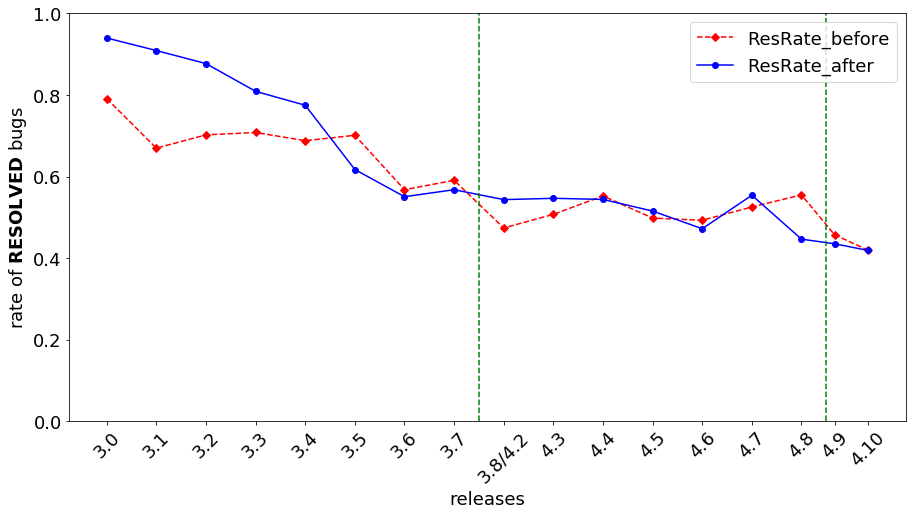

In [7]:
data = df_yearly_stats_first.copy()

compare_distributions(data,'Ratio_R_B','Ratio_R_A',False)

x = get_x_axis_tick_placement()

fig, ax = plt.subplots()

data = sort_df(data,'version')

data['label'] = ''
for index,row in data.iterrows():
    rel = row['version']
    date = relase_creation_ts_all[rel]
    date = date[:date.find(' ')]
    date = date[:date.rfind('-')]
    if rel=='4.2':
        rel='3.8/4.2'
    data.loc[index,'label'] = rel
data = data.set_index('version')
fig.set_figheight(7.5)
fig.set_figwidth(15)

ax.plot(x,data[['Ratio_R_B']],label='ResRate_before',color='red',marker='D',linestyle='--')
ax.plot(x,data[['Ratio_R_A']],label='ResRate_after',color='blue',marker='o',linestyle='-')

ax.legend(fontsize=18,loc=1)
plt.xlabel('releases', fontsize=18)
plt.ylabel('rate of ' + r"$\it{" + r"\bf{"+ 'RESOLVED' +  "}"+ "}$" + ' bugs', fontsize=18)

plt.axvline(x=14.5, c='g',linestyle='--')
plt.axvline(x=7.5, c='g',linestyle='--')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
    tick.label.set_rotation(45)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
plt.xticks(x, data.label.values.tolist())
plt.ylim(0,1)
plt.show()
ax.get_figure().savefig(FIGS_PATH+os.sep+'rq1_res_before_after.pdf', bbox_inches="tight")

Regression for:Ratio_R_B
Coefficients: 
 [[-9.0104126e-07]]
Mean squared error:0.0023529457815268215
Variance score:-81.19686139564436
R squared:0.7854030340028331
linear_regressor.intercept_:[1.41859856]


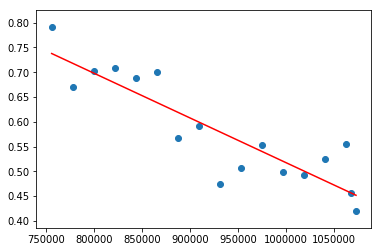

In [8]:
#regression for the resolution rate BEFORE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

for_fig = df_yearly_stats_first.copy()

run_linear_regression(for_fig,"date_int","Ratio_R_B")

Regression for:Ratio_R_A
Coefficients: 
 [[-1.51243609e-06]]
Mean squared error:0.0038635532523358016
Variance score:-81.19685622921554
R squared:0.8626371116511257
linear_regressor.intercept_:[2.02250878]


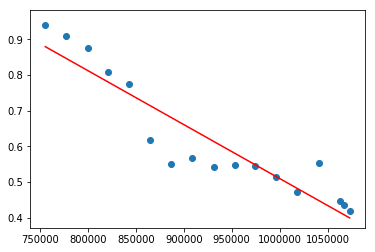

In [9]:
#regression for the resolution rate AFTER
run_linear_regression(for_fig,"date_int","Ratio_R_A")

In [10]:
##FIXING RATES

In [11]:
df_yearly_stats_first['Fix_rate_reported_before'] = df_yearly_stats_first['RBFB'] / df_yearly_stats_first['before_release']
df_yearly_stats_first['Fix_rate_reported_after'] = df_yearly_stats_first['RAFA'] / df_yearly_stats_first['after_release']
df_yearly_stats_first

,version,RAFA,RARA,RBFA,RBFB,RBRA,RBRB,Ratio_F_A,Ratio_F_B,Ratio_R_A,Ratio_R_B,after_release,before_release,total,date,date_int,Fix_rate_reported_before,Fix_rate_reported_after
0,3.0,2804.0,6551.0,1321.0,7870.0,3324.0,14213.0,0.428026,0.553718,0.939885,0.791061,6970.0,17967.0,24937.0,2004-06-25 00:00:00,7.556400e+05,0.438025,0.402296
1,3.1,2069.0,5198.0,715.0,4857.0,1911.0,8163.0,0.398038,0.595002,0.909059,0.669647,5718.0,12190.0,17908.0,2005-06-28 00:00:00,7.777200e+05,0.398441,0.361840
2,3.2,1829.0,4696.0,996.0,4525.0,2294.0,7360.0,0.389480,0.614810,0.877101,0.702290,5354.0,10480.0,15834.0,2006-06-29 00:00:00,7.996800e+05,0.431775,0.341614
3,3.3,1778.0,3681.0,817.0,3847.0,1442.0,5730.0,0.483021,0.671379,0.809011,0.708107,4550.0,8092.0,12642.0,2007-06-28 00:00:00,8.215200e+05,0.475408,0.390769
4,3.4,1749.0,3548.0,767.0,3870.0,1349.0,5456.0,0.492954,0.709311,0.774842,0.687933,4579.0,7931.0,12510.0,2008-06-25 00:00:00,8.433000e+05,0.487959,0.381961
5,3.5,994.0,1666.0,546.0,3386.0,847.0,4767.0,0.596639,0.710300,0.617266,0.701236,2699.0,6798.0,9497.0,2009-06-24 00:00:00,8.651400e+05,0.498088,0.368285
6,3.6,772.0,1262.0,363.0,2235.0,520.0,2565.0,0.611727,0.871345,0.550611,0.567729,2292.0,4518.0,6810.0,2010-06-23 00:00:00,8.869800e+05,0.494688,0.336824
7,3.7,750.0,1111.0,227.0,1426.0,325.0,1728.0,0.675068,0.825231,0.567706,0.590769,1957.0,2925.0,4882.0,2011-06-22 00:00:00,9.088200e+05,0.487521,0.383240
8,4.2,1433.0,2015.0,361.0,1263.0,514.0,1642.0,0.711166,0.769184,0.543420,0.473882,3708.0,3465.0,7173.0,2012-06-27 00:00:00,9.310800e+05,0.364502,0.386462
9,4.3,648.0,997.0,241.0,745.0,337.0,969.0,0.649950,0.768834,0.546601,0.507330,1824.0,1910.0,3734.0,2013-06-26 20:00:00,9.529700e+05,0.390052,0.355263


Fixed based on resolved
At least one sample not normally distributed
WILCOXON RANK SUMS
Statistically significant difference found
RanksumsResult(statistic=2.3249384090832703, pvalue=0.020075253803708427)
0.4671280276816609
medium
Fixed based on reported
At least one sample not normally distributed
WILCOXON RANK SUMS
Statistically significant difference found
RanksumsResult(statistic=3.9782279444313735, pvalue=6.943079403239787e-05)
0.7993079584775087
large


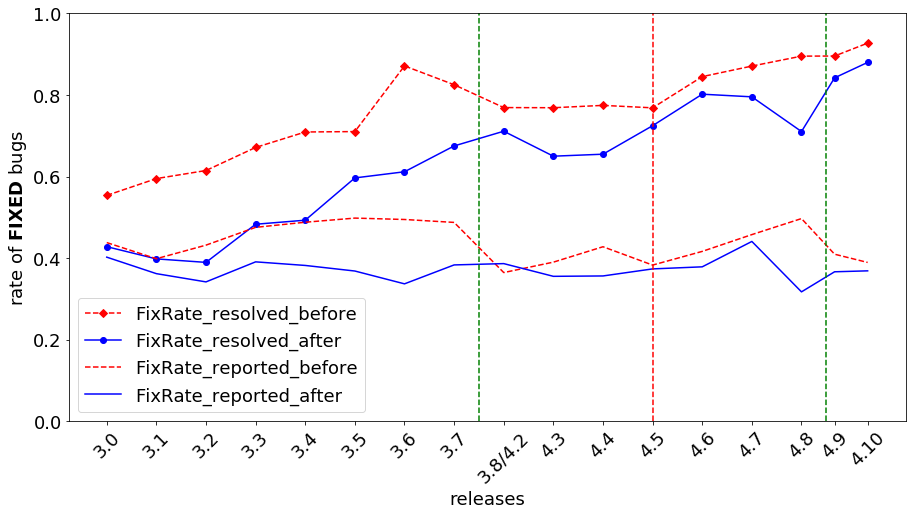

In [12]:
data = df_yearly_stats_first.copy()

print('Fixed based on resolved')
compare_distributions(data,'Ratio_F_B','Ratio_F_A',False)

print('=======')
print('Fixed based on reported')
compare_distributions(data,'Fix_rate_reported_before','Fix_rate_reported_after',False)

x = get_x_axis_tick_placement()

fig, ax = plt.subplots()

data = sort_df(data,'version')

data['label'] = ''
for index,row in data.iterrows():
    rel = row['version']
    date = relase_creation_ts_all[rel]
    date = date[:date.find(' ')]
    date = date[:date.rfind('-')]
    #stats2.loc[index,'label'] = rel+' ('+date+')'
    #stats2.loc[index,'label'] = date+' - '+rel
    if rel=='4.2':
        rel='3.8/4.2'
    data.loc[index,'label'] = rel
data = data.set_index('version')
fig.set_figheight(7.5)
fig.set_figwidth(15)

ax.plot(x,data[['Ratio_F_B']],label='FixRate_resolved_before',color='red',marker='D',linestyle='--')
ax.plot(x,data[['Ratio_F_A']],label='FixRate_resolved_after',color='blue',marker='o',linestyle='-')

ax.plot(x,data[['Fix_rate_reported_before']],label='FixRate_reported_before',color='red',linestyle='--')
ax.plot(x,data[['Fix_rate_reported_after']],label='FixRate_reported_after',color='blue',linestyle='-')


ax.legend(fontsize=18)
plt.xlabel('releases', fontsize=18)
plt.ylabel('rate of ' + r"$\it{" + r"\bf{"+ 'FIXED' +  "}"+ "}$" + ' bugs', fontsize=18)

plt.axvline(x=14.5, c='g',linestyle='--')
ax.axvline(x=11, c='r',linestyle='--')
plt.axvline(x=7.5, c='g',linestyle='--')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
    tick.label.set_rotation(45)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
plt.xticks(x, data.label.values.tolist())
plt.ylim(0,1)
plt.show()
ax.get_figure().savefig(FIGS_PATH+os.sep+'rq1_fix_before_after.pdf', bbox_inches="tight")

Regression for:Ratio_F_B
Coefficients: 
 [[9.60172142e-07]]
Mean squared error:0.0022114623954398215
Variance score:-81.1968250870689
R squared:0.8155632559794771
linear_regressor.intercept_:[-0.12245659]


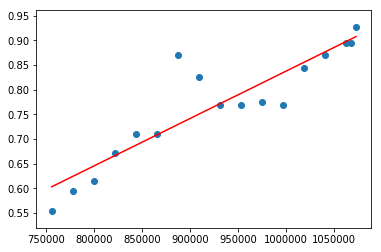

In [13]:
#regression for the fix rate resolved BEFORE
run_linear_regression(df_yearly_stats_first,"date_int","Ratio_F_B")

Regression for:Ratio_F_A
Coefficients: 
 [[1.38137173e-06]]
Mean squared error:0.0022743766606230045
Variance score:-81.19684710464678
R squared:0.8989815953242387
linear_regressor.intercept_:[-0.64398447]


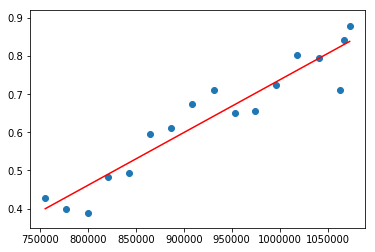

In [14]:
#regression for the fix rate resolved AFTER
run_linear_regression(df_yearly_stats_first,"date_int","Ratio_F_A")

Regression for:Fix_rate_reported_before
Coefficients: 
 [[-9.46115548e-08]]
Mean squared error:0.0018533726806757194
Variance score:-81.19688504062414
R squared:0.04873262062935668
linear_regressor.intercept_:[0.52585943]


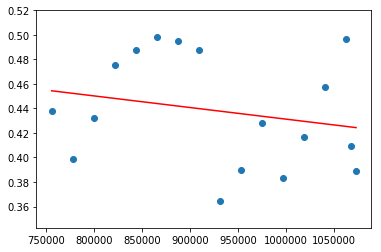

In [15]:
#regression for the fix rate reported BEFORE
run_linear_regression(df_yearly_stats_first,"date_int","Fix_rate_reported_before")

Regression for:Fix_rate_reported_after
Coefficients: 
 [[-1.37020115e-08]]
Mean squared error:0.0007232664145167925
Variance score:-81.19689658296487
R squared:0.0027457930067064096
linear_regressor.intercept_:[0.38388614]


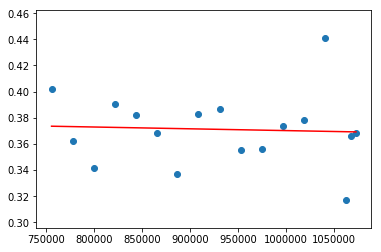

In [16]:
#regression for the fix rate reported AFTER
run_linear_regression(df_yearly_stats_first,"date_int","Fix_rate_reported_after")